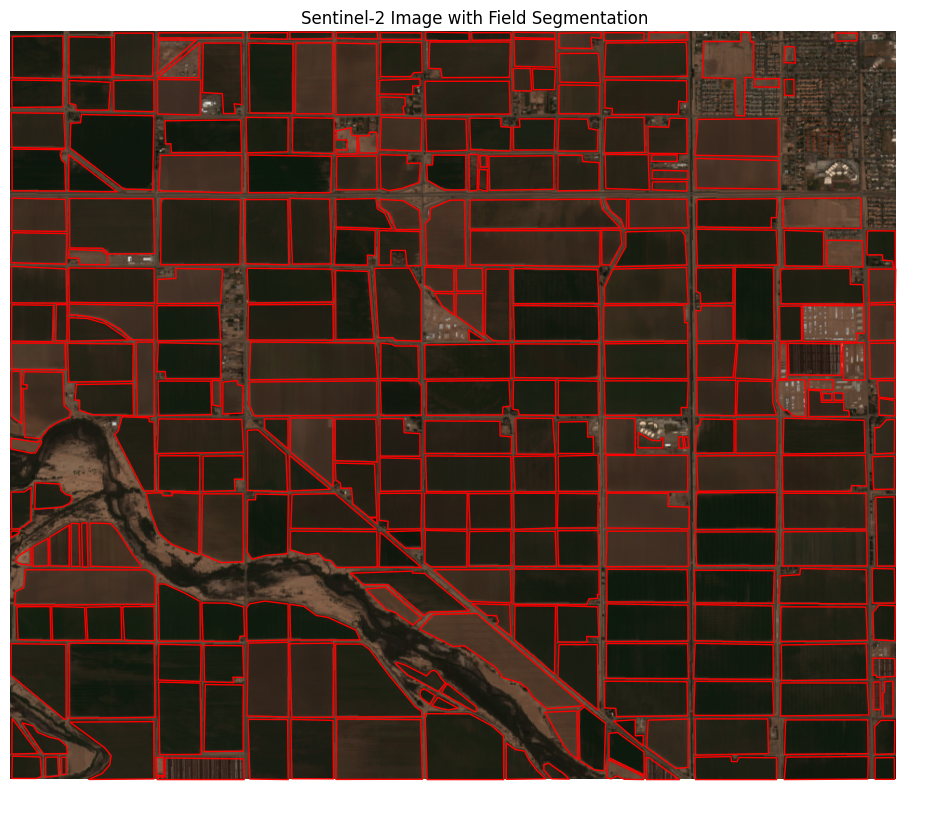

In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
from shapely.geometry import Polygon

def load_satellite_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read(), src.meta

def load_annotations(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def create_polygon(coordinates):
    # Reshape the coordinates into pairs
    coords = np.array(coordinates).reshape(-1, 2)
    return Polygon(coords)

def visualize_dataset(image_path, annotation_path):
    # Load satellite image
    image, meta = load_satellite_image(image_path)
    
    # Load annotations
    annotations = load_annotations(annotation_path)
    
    # Find the correct image annotations
    image_name = image_path.split('/')[-1]
    image_annotations = next(img for img in annotations['images'] if img['file_name'] == image_name)
    
    # Create polygons from the annotations
    polygons = [create_polygon(ann['segmentation']) for ann in image_annotations['annotations']]
    gdf = gpd.GeoDataFrame(geometry=polygons)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Display the satellite image (using RGB bands)
    rgb_bands = [3, 2, 1]  # Assuming B4=Red, B3=Green, B2=Blue
    rgb_image = np.dstack([image[i] for i in rgb_bands])
    rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)
    ax.imshow(rgb_image)
    
    # Plot the polygons
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')
    
    plt.title('Sentinel-2 Image with Field Segmentation')
    plt.axis('off')
    plt.show()



visualize_dataset('train_images/images/train_3.tif', 'train_annotation.json')

Image dimensions: 952x804
Number of bands: 12


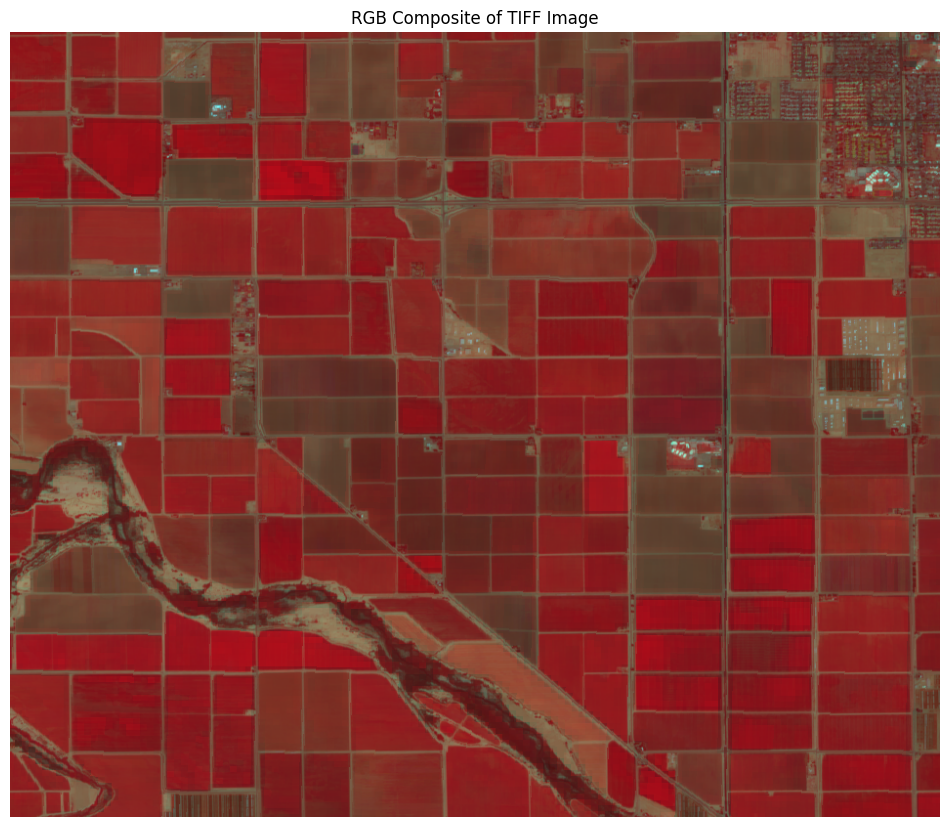

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def display_tiff(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        
        height = src.height
        width = src.width
        bands = src.count
        
        print(f"Image dimensions: {width}x{height}")
        print(f"Number of bands: {bands}")
        
        # If the image has more than 3 bands, we'll use the first three for RGB display
        if bands >= 3:
            # Assuming the first three bands correspond to RGB
            rgb_bands = [9,3,2]  # Remember, rasterio uses 1-based indexing, but numpy uses 0-based
            rgb_image = np.dstack([image[i] for i in rgb_bands])
            
            # Normalize the data to 0-255 for display
            rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)
            
            plt.figure(figsize=(12, 12))
            plt.imshow(rgb_image)
            plt.axis('off')
            plt.title('RGB Composite of TIFF Image')
            plt.show()
        else:
            print("The image has fewer than 3 bands. Displaying first band as grayscale.")
            plt.figure(figsize=(12, 12))
            plt.imshow(image[0], cmap='gray')
            plt.axis('off')
            plt.title('First Band of TIFF Image (Grayscale)')
            plt.show()

display_tiff('train_images/images/train_3.tif')

Image dimensions: 952x804
Number of bands: 12


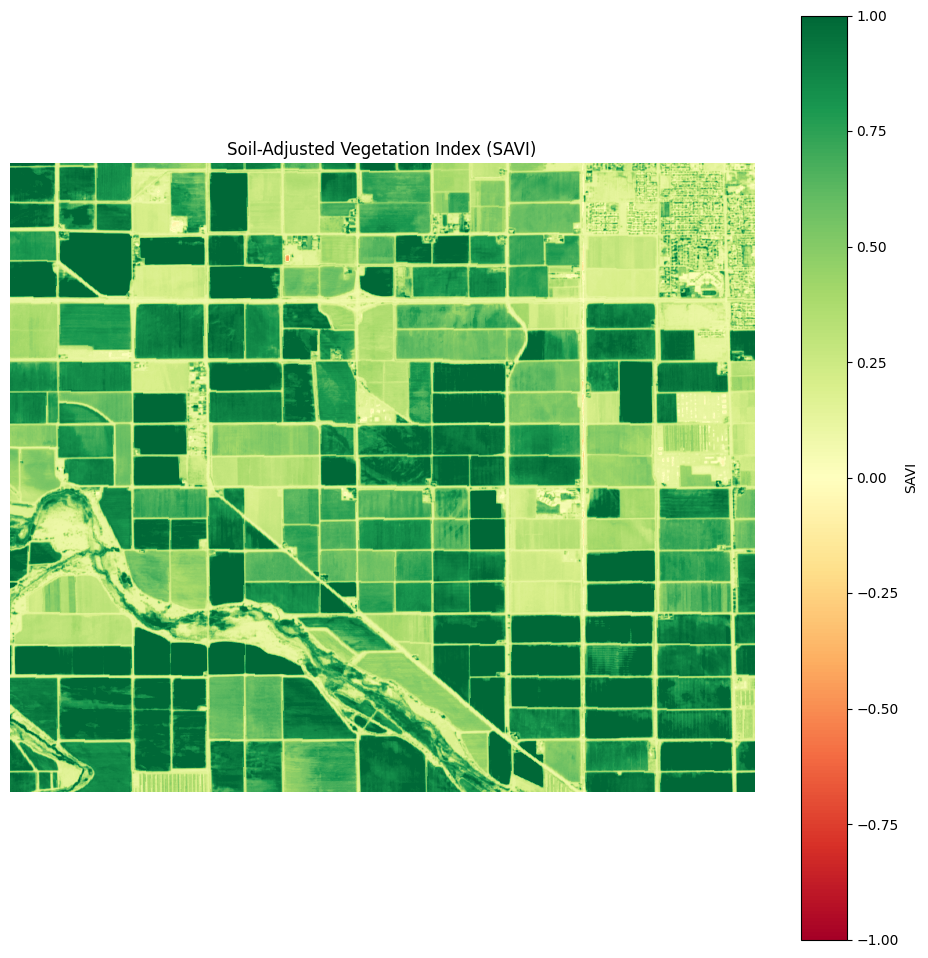

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def display_tiff(image_path, index='NDVI'):
    with rasterio.open(image_path) as src:
        image = src.read()
        
        height = src.height
        width = src.width
        bands = src.count
        
        print(f"Image dimensions: {width}x{height}")
        print(f"Number of bands: {bands}")
        
        # Ensure we have the necessary bands for NDVI or SAVI
        if bands < 8:
            print("The image doesn't have enough bands for NDVI or SAVI calculation.")
            return
        
        # Extract bands 4 (Red) and 8 (NIR)
        red = image[3].astype(float)  # B4
        nir = image[7].astype(float)  # B8
        
        # Calculate the chosen index
        if index == 'NDVI':
            result = (nir - red) / (nir + red)
            title = 'Normalized Difference Vegetation Index (NDVI)'
        elif index == 'SAVI':
            L = 0.5  # soil brightness correction factor
            result = ((nir - red) / (nir + red + L)) * (1 + L)
            title = 'Soil-Adjusted Vegetation Index (SAVI)'
        else:
            print("Invalid index. Choose 'NDVI' or 'SAVI'.")
            return
        
        # Create a colormap
        cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap
        
        # Plot the result
        plt.figure(figsize=(12, 12))
        im = plt.imshow(result, cmap=cmap, vmin=-1, vmax=1)
        plt.colorbar(im, label=index)
        plt.axis('off')
        plt.title(title)
        plt.show()

# Example usage:
display_tiff('train_images/images/train_3.tif', index='SAVI')
# To use SAVI instead, use:
# display_tiff('train_images/images/train_3.tif', index='SAVI')